#### import the packages

In [1]:
# import the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)
import scipy.stats as stats
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

/Users/sb/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/sb/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/sb/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/sb/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loo

#### data import

In [2]:
# import the data under consideration
bankloans = pd.read_csv('bankloans.csv' )
bankloans.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


#### UDFs

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

#### data inspection

In [12]:
# check the metadata
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [13]:
# profiling using pandas_profiling
# screen the variables and make a note of potential variables for model refinement
profile_report = pandas_profiling.ProfileReport(bankloans)
profile_report.to_file(output_file = 'profilereport.html')

TypeError: to_file() got an unexpected keyword argument 'output_file'

In [14]:
# separate the categorical and continuous variable names
numeric_var_names = [key for key in dict(bankloans.dtypes) 
                     if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names = [key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

In [15]:
# print the variable names in both the variables
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [16]:
# get the dataframe of only continuous variables
bankloans_num = bankloans[numeric_var_names]

In [17]:
# get the data audit report for all the variables
num_summary = bankloans_num.apply(continuous_var_summary).T
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


#### seperate out the data for existing and the new customers

In [18]:
bankloans_existing = bankloans_num[bankloans_num.default.isnull() == 0]
bankloans_new = bankloans_num[bankloans_num.default.isnull() == 1]

#### data prepration/data cleaning

In [19]:
# Handling Outliers
bankloans_existing = bankloans_existing.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [20]:
# Handling missings
bankloans_existing = bankloans_existing.apply(lambda x: missing_imputation(x))

#### bi variate analysis to identify corr 

In [21]:
# correlation matrix
corr_matrix = bankloans_existing.corr()
#corr_matrix.to_csv('corr.csv')

In [8]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (12, 9))
sns.heatmap(bankloans_existing.corr(), annot=True)

NameError: name 'bankloans_existing' is not defined

<Figure size 1200x900 with 0 Axes>

### Building logistic Regression Model

In [22]:
# import the package for logistic regression
import statsmodels.formula.api as sm

In [23]:
# Train and Test split
train, test = train_test_split(bankloans_existing, test_size = 0.3, random_state =  42)

In [24]:
# print the columns
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [25]:
#'default ~ age + ed + employ + address + income + debtinc + creddebt + othdebt'

In [26]:
# execute a model for the X variables
m1 = sm.logit(formula = 'default ~  address + employ + income + debtinc + creddebt', 
                  data = train).fit() 

Optimization terminated successfully.
         Current function value: 0.430694
         Iterations 7


In [27]:
# print the model summary stats 
print(m1.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.266     
Dependent Variable: default          AIC:              434.0800  
Date:               2019-09-08 16:35 BIC:              459.2465  
No. Observations:   490              Log-Likelihood:   -211.04   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      3.2769e-31
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -0.8689    0.3421  -2.5397  0.0111  -1.5395  -0.1983
address       -0.0602    0.0220  -2.7339  0.0063  -0.1034  -0.0170
employ        -0.2360    0.0339  -6.9599  0.0000  -0.3024  -0.1695
income         0.0036    0.007

#### Data Exploratory Analysis
    - Variable Reduction using Somer's D values
    - Bi-variate analysis technique to check the predictive power of each independent against dependent
    - cutoff is 0.2 or 20% below which the variable is insignificant

In [28]:
# list all the columns 
print(bankloans_existing.columns)

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')


In [29]:
# example to get the Somer's D for one variable
logreg_model = sm.logit('default ~ debtinc', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6


In [30]:
# predict the probabilities
p = logreg_model.predict(bankloans_existing)

In [31]:
# get the AUC
metrics.roc_auc_score(bankloans_existing['default'], p)

0.7352527718764202

In [68]:
# get the meaning of this statement
# 2 * metrics.roc_auc_score(bankloans_existing['default'], p) - 1

#### get the Somer's D values for all the X variables

In [29]:
# empty dataframe
somersd_df = pd.DataFrame()

# iterate for each of the X - dependant variables and get the Somer's D value
for num_variable in bankloans_existing.columns.difference(['default']):
    
    # execute teh logit model
    logreg = sm.logit(formula = str('default ~ ') + str(num_variable), data = bankloans_existing).fit()
    
    # get the predicted probabilities and create a dataframe with the predicted values
    y_score = pd.DataFrame(logreg.predict())
    
    # name the column of the df as score
    y_score.columns = ['Score']
    
    # calculate the Somer's D values
    somers_d = 2 * metrics.roc_auc_score(bankloans_existing['default'], y_score) - 1
    
    # place the variable name and the Somers' D score in a temp dataframe
    temp = pd.DataFrame([num_variable, somers_d]).T
    temp.columns = ['Variable Name', 'SomersD']
    
    # append the data in the dataframe for all the X variables
    somersd_df = pd.concat([somersd_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


In [30]:
# print the Somer's D values for all variables
# Bi-variate analysis to check the predictive power of each independent against dependent
somersd_df.sort_values(by = 'SomersD', ascending = False)

,Variable Name,SomersD
0,debtinc,0.470506
0,employ,0.409138
0,creddebt,0.272378
0,address,0.222384
0,age,0.206329
0,income,0.200273
0,othdebt,0.173806
0,ed,0.148302


#### VIF - Variance Inflation Factor

In [32]:
# get all the dependent avriables
features = ' + '.join(bankloans_existing.columns.difference(['default']))
features

'address + age + creddebt + debtinc + ed + employ + income + othdebt'

In [33]:
# run the dmatrices
a, b = dmatrices('default ~ ' + features, data = bankloans_existing, return_type = 'dataframe')

# get the VIF
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

vif

,VIF Factor,features
0,36.910987,Intercept
1,1.561802,address
2,2.037593,age
3,2.628899,creddebt
4,3.910509,debtinc
5,1.287345,ed
6,2.401544,employ
7,5.121585,income
8,4.562072,othdebt


### predict the values

In [35]:
# predict the values on training and testing
train['pred_prob'] = m1.predict(train)
train_predict = m1.predict(train)
test_predict = m1.predict(test)
train.head(20)

/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,pred_prob
357,24.0,2,0.0,2.0,15.0,16.100,0.321195,2.093805,1.0,0.614789
649,29.0,2,5.0,7.0,28.0,18.700,2.125816,3.110184,0.0,0.563556
291,33.0,4,9.0,8.0,32.0,5.500,0.496320,1.263680,0.0,0.065281
420,46.0,1,1.0,15.0,21.0,14.800,1.376844,1.731156,1.0,0.492845
177,28.0,2,7.0,2.0,34.0,7.000,0.359380,2.020620,0.0,0.143656
456,37.0,4,9.0,16.0,177.0,5.900,0.887655,9.555345,0.0,0.085058
444,43.0,4,18.0,14.0,190.3,6.500,9.891428,12.958530,1.0,0.696685
83,35.0,4,4.0,16.0,29.0,11.000,1.843820,1.346180,0.0,0.311932
453,39.0,1,0.0,8.0,39.0,7.900,1.066026,2.014974,0.0,0.498220
354,41.0,3,18.0,6.0,71.0,15.700,6.565583,4.581417,1.0,0.424809


- p (Default = 1) = exp(LE) / (1 + exp(LE)) 

#### check model accuracy

In [36]:
# model accuracy | Method 1: AUC
train_auc = metrics.roc_auc_score(train['default'], train_predict)
test_auc = metrics.roc_auc_score(test['default'], test_predict)

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)

The AUC for the model built on the Train Data is :  0.8371205768908268
The AUC for the model built on the Test Data is :  0.8859170997591583


In [38]:
print("Response rate (Proportion of 1 vs 0):", train['default'].mean())
print("Average of predicted probalities:", train_predict.mean())

Response rate (Proportion of 1 vs 0): 0.27346938775510204
Average of predicted probalities: 0.27346938775510177


#### combine the actual Y values with predicted probabilities

In [94]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(train_predict)
train_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
train_pf = pd.concat([train['default'], train_predicted_prob], axis = 1)
train_pf.columns = ['actual', 'prob']

In [95]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(test_predict)
test_predicted_prob.columns = ['prob']

# making a DataFrame with actual and prob columns
test_pf = pd.concat([test['default'], test_predicted_prob], axis=1)
test_pf.columns = ['actual','prob']

In [116]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix( train['default'],
                            train_predict>0.23,[1,0])
cm

array([[115,  19],
       [114, 242]])

In [117]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

Text(0.5,15,'Predicted label')

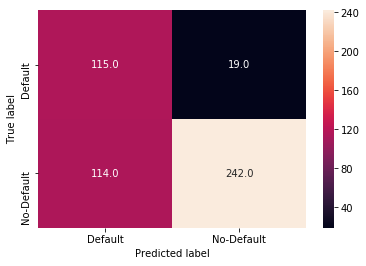

In [118]:
sn.heatmap(cm, annot=True,  fmt='.1f', xticklabels = ["Default", "No-Default"] , yticklabels = ["Default", "No-Default"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### calculate the confusion matrix parameters

In [113]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_pf.copy()

for cut_off in np.linspace(0,1,100):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)

roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df

,cutoff,sensitivity,specificity,accuracy,total
0,0.000000,1.000000,0.000000,0.273469,1.000000
0,0.010101,1.000000,0.095506,0.342857,1.095506
0,0.020202,1.000000,0.160112,0.389796,1.160112
0,0.030303,1.000000,0.205056,0.422449,1.205056
0,0.040404,0.992537,0.258427,0.459184,1.250964
0,0.050505,0.985075,0.297753,0.485714,1.282827
0,0.060606,0.977612,0.328652,0.506122,1.306264
0,0.070707,0.970149,0.351124,0.520408,1.321273
0,0.080808,0.962687,0.373596,0.534694,1.336282
0,0.090909,0.947761,0.390449,0.542857,1.338211


#### finding ideal cut-off
    - Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

In [110]:
# cut-off based on highest sum(sensitivity + specicity) - common way of identifying cut-off
roc_like_df[roc_like_df['total'] == roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.232323,0.858209,0.685393,0.732653,1.543602


In [112]:
# cut-off based on highest accuracy - can be misleading in case imbalanced data
roc_like_df[roc_like_df['accuracy'] == roc_like_df['accuracy'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.484848,0.507463,0.91573,0.804082,1.423193


#### do the final predictions at the 0.23 as cutoff

In [137]:
test_pf['predicted'] = test_pf['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_pf['predicted'] = train_pf['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [138]:
# confusion matrix of training dataset
pd.crosstab(train_pf['actual'], train_pf['predicted'])

predicted,0,1
actual,,
0.0,242,114
1.0,19,115


In [139]:
# confusion matrix of testing dataset
pd.crosstab(test_pf['actual'], test_pf['predicted'])

predicted,0,1
actual,,
0.0,117,44
1.0,8,41


In [140]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_pf.actual, train_pf.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_pf.actual, test_pf.predicted))

The overall accuracy score for the Train Data is :  0.7285714285714285
The overall accuracy score for the Test Data  is :  0.7523809523809524


## Predicting new customers (Implementation of Model on new data)

In [ ]:
# predciting new customers good or bad
bankloans_new.head()

#### before scoring new customers, you need to process the data using the sames steps you followed while building the model

In [120]:
bankloans_new['prob'] = m1.predict(bankloans_new)
bankloans_new.head()

/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,age,ed,employ,address,income,debtinc,creddebt,othdebt,default,prob
700,36,1,16,13,32,10.9,0.544128,2.943872,NaN,0.015101
701,50,1,6,27,21,12.9,1.316574,1.392426,NaN,0.108179
702,40,1,9,9,33,17.0,4.880700,0.729300,NaN,0.656100
703,31,1,5,7,23,2.0,0.046000,0.414000,NaN,0.098785
704,29,1,4,0,24,7.8,0.866736,1.005264,NaN,0.344486


In [121]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

/Users/sb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [122]:
bankloans_new.default.value_counts()

0    86
1    64
Name: default, dtype: int64

#### We are rejecting applications for 67 customers based on cut-off = 0.23

### Decile Analysis

In [ ]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutiny
#6th decile onwards - low risk customers - accept the application

In [123]:
#Decile analysis for validation of models - Business validation
train_pf['Deciles'] = pd.qcut(train_pf['prob'], 10, labels = False)
test_pf['Deciles'] = pd.qcut(test_pf['prob'], 10, labels = False)

#### Decile Analysis for train data

In [129]:
no_1s = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_pf[['Deciles','actual']].groupby(train_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_pf[['Deciles','prob']].groupby(train_pf.Deciles).min().sort_index(ascending=False)['prob']

In [130]:
Decile_analysis_train = pd.concat([ min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [131]:
Decile_analysis_train.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [132]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')
Decile_analysis_train

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.635499,0.986634,37.0,12.0,49
8,0.490391,0.632970,31.0,18.0,49
7,0.379694,0.484824,15.0,34.0,49
6,0.283197,0.378689,20.0,29.0,49
5,0.208861,0.281603,15.0,34.0,49
4,0.153350,0.208425,5.0,44.0,49
3,0.091615,0.151793,4.0,45.0,49
2,0.043280,0.090953,5.0,44.0,49
1,0.015427,0.042930,2.0,47.0,49


#### Decile Analysis for test data

In [133]:
no_1s = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_pf[['Deciles','actual']].groupby(test_pf.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_pf[['Deciles','prob']].groupby(test_pf.Deciles).min().sort_index(ascending=False)['prob']

In [134]:
Decile_analysis_test = pd.concat([min_prob, max_prob, no_1s, no_total-no_1s, no_total], axis=1)

In [135]:
Decile_analysis_test.columns = ['Min_prob', 'Max_prob', '#1', '#0', 'Total']

In [136]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')
Decile_analysis_test

,Min_prob,Max_prob,#1,#0,Total
Deciles,,,,,
9,0.681955,0.972962,20.0,1.0,21
8,0.480938,0.676101,9.0,12.0,21
7,0.336827,0.477359,8.0,13.0,21
6,0.234780,0.314097,4.0,17.0,21
5,0.168104,0.232668,3.0,18.0,21
4,0.120567,0.165883,2.0,19.0,21
3,0.072999,0.113375,2.0,19.0,21
2,0.046943,0.069503,1.0,20.0,21
1,0.019471,0.041684,0.0,21.0,21
